# Community Detection: Benchmarks and Evaluation Tutorial

## Learning Objectives
- Understand how to evaluate community detection algorithms systematically
- Learn to use artificial benchmark graphs with known community structure
- Apply partition similarity measures to quantify algorithm performance
- Interpret evaluation results to assess algorithm strengths and limitations

This tutorial provides a hands-on approach to evaluating community detection algorithms using both synthetic and real-world benchmark networks. We'll explore how to generate graphs with known community structures, apply detection algorithms, and measure how well the detected communities match the ground truth.

## 1. Setup

First, let's import the necessary libraries and define helper functions.

In [15]:
# Import libraries for network analysis and visualization
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import pandas as pd

# For community detection algorithms
from networkx.algorithms import community

### Helper Functions

Let's define utility functions for working with community structures and visualizing results.

In [16]:
# Helper function: Convert partition format (list of sets) to labels array
def partition_to_labels(partition, graph):
    """
    Convert a partition (list of sets of nodes) to a node label array.
    
    Parameters:
    -----------
    partition : list of sets
        Each set contains nodes belonging to the same community
    graph : networkx.Graph
        The graph being partitioned
        
    Returns:
    --------
    numpy.ndarray
        Array of community labels (integers) for each node
    """
    node_to_idx = {node: i for i, node in enumerate(graph.nodes())}
    labels = np.zeros(graph.number_of_nodes(), dtype=int)
    
    for i, community_nodes in enumerate(partition):
        try:
            for node in community_nodes:
                labels[node_to_idx[node]] = i
        except KeyError:
            pass

    return labels

In [17]:
# Helper function: Visualize communities in a graph
def draw_communities(graph, partition, pos=None, figsize=(10, 8), title="Graph with Communities", 
                     node_size=100, with_labels=False, alpha=0.2):
    """
    Draw a graph with nodes colored by community membership.
    
    Parameters:
    -----------
    graph : networkx.Graph
        The graph to visualize
    partition : list of sets
        Each set contains nodes belonging to the same community
    pos : dict, optional
        Node positions for visualization
    figsize : tuple, optional
        Figure size
    title : str, optional
        Plot title
    node_size : int, optional
        Size of nodes in visualization
    with_labels : bool, optional
        Whether to show node labels
    alpha : float, optional
        Transparency of edges (default: 0.5)
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)  # Create explicit axes object
    
    if pos is None:
        pos = nx.spring_layout(graph, seed=42)
    
    # Create node-to-community mapping
    node_to_comm = {}
    for i, comm in enumerate(partition):
        for node in comm:
            node_to_comm[node] = i
    
    # Get unique communities and assign colors
    unique_comms = sorted(set(node_to_comm.values()))
    n_communities = len(unique_comms)
    
    cmap = plt.get_cmap('tab20', n_communities)  # Use a colormap with distinct colors
    
    # Create node color list based on community membership
    node_colors = [node_to_comm.get(node, 0) for node in graph.nodes()]
    
    # Draw nodes with community-based colors but without labels
    nodes = nx.draw_networkx_nodes(graph, pos,
                                  node_color=node_colors,
                                  cmap=cmap,
                                  node_size=node_size,
                                  vmin=0,
                                  vmax=max(unique_comms),
                                  edgecolors='black',
                                  ax=ax)
    
    # Draw edges with reduced opacity
    nx.draw_networkx_edges(graph, pos, alpha=alpha, ax=ax)  
    if with_labels:
        nx.draw_networkx_labels(graph, pos, font_size=8, ax=ax)
    
    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

## 2. Artificial Benchmarks

Artificial benchmarks are essential for community detection evaluation because they provide graphs with **known ground truth** - we create the communities ourselves and can precisely control their properties.

### 2.1 Planted Partition Model (PPM) / Stochastic Block Model (SBM)

The Planted Partition Model is a special case of the more general Stochastic Block Model where:

- Nodes are pre-assigned to communities
- Edges are added probabilistically:
  - $p_{int}$ = probability of connecting nodes within the same community
  - $p_{ext}$ = probability of connecting nodes from different communities
  - Typically $p_{int} > p_{ext}$ for meaningful community structure

The **mixing parameter** $\mu$ quantifies the strength of community structure:

$$\mu = \frac{\langle k^{ext} \rangle}{\langle k \rangle}$$

Where:
- $\langle k^{ext} \rangle$ = average number of external edges per node
- $\langle k \rangle$ = average total degree per node

**Interpretation**:
- $\mu = 0$ → Perfect communities (no external connections)
- $\mu = 0.5$ → Threshold for detectability with many algorithms
- $\mu = 1$ → No community structure (random connections)

In [18]:
# Define PPM parameters
q = 4      # Number of communities
nc = 30    # Nodes per community (smaller for clearer visualization)
N = q * nc  # Total nodes
p_int = 0.3 # High probability within communities
p_ext = 0.01 # Low probability between communities

# Calculate expected mixing parameter for these probabilities
k_int = p_int * (nc - 1)  # Expected internal degree
k_ext = p_ext * (N - nc)  # Expected external degree
k_total = k_int + k_ext   # Expected total degree
mu_expected = k_ext / k_total

print(f"Generating PPM with parameters:")
print(f"- Communities: {q}")
print(f"- Nodes per community: {nc}")
print(f"- Internal edge probability: {p_int}")
print(f"- External edge probability: {p_ext}")
print(f"- Expected mixing parameter: μ ≈ {mu_expected:.2f}")

# Generate the PPM graph
G_ppm = nx.planted_partition_graph(q, nc, p_int, p_ext, seed=42)

# Create ground truth partition for PPM
ground_truth_ppm_partition = [set(range(i*nc, (i+1)*nc)) for i in range(q)]
ground_truth_ppm_labels = partition_to_labels(ground_truth_ppm_partition, G_ppm)

Generating PPM with parameters:
- Communities: 4
- Nodes per community: 30
- Internal edge probability: 0.3
- External edge probability: 0.01
- Expected mixing parameter: μ ≈ 0.09


In [19]:
# Analyze the created PPM graph
internal_edges = 0
total_edges = G_ppm.number_of_edges()

for u, v in G_ppm.edges():
    u_comm = u // nc
    v_comm = v // nc
    if u_comm == v_comm:
        internal_edges += 1

external_edges = total_edges - internal_edges
actual_mu = external_edges / total_edges

print(f"\nGenerated graph properties:")
print(f"- Nodes: {G_ppm.number_of_nodes()}")
print(f"- Edges: {G_ppm.number_of_edges()}")
print(f"- Internal edges: {internal_edges}")
print(f"- External edges: {external_edges}")
print(f"- Actual mixing parameter: μ = {actual_mu:.2f}")


Generated graph properties:
- Nodes: 120
- Edges: 565
- Internal edges: 504
- External edges: 61
- Actual mixing parameter: μ = 0.11


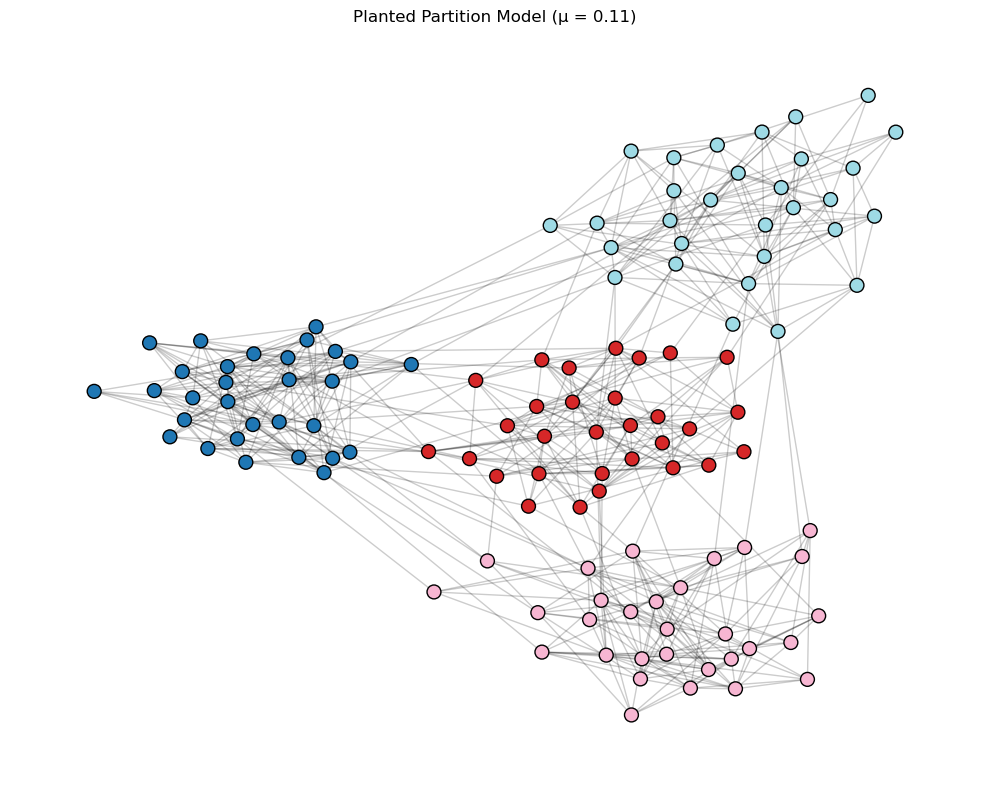

In [20]:
# Visualize the PPM graph with communities
draw_communities(G_ppm, ground_truth_ppm_partition, 
                title=f"Planted Partition Model (μ = {actual_mu:.2f})")

### 2.2 Girvan-Newman (GN) Benchmark

The Girvan-Newman benchmark is a specific instance of the Planted Partition Model with:
- $N = 128$ nodes
- $q = 4$ equal-sized communities (32 nodes each)
- Constant average degree $\langle k \rangle = 16$

The benchmark's difficulty is controlled by varying $\mu$, the mixing parameter.

**Why is this benchmark important?**
It was one of the first standardized benchmarks for community detection, allowing fair comparison between algorithms. However, it has limitations:
- Fixed community sizes (all the same)
- Uniform degree distribution (unlike most real networks)
- Limited scalability

Let's implement the GN benchmark by calculating the appropriate internal and external edge probabilities to achieve a target mixing parameter:

In [21]:
# Define GN benchmark parameters
N_gn = 128      # Total nodes
q_gn = 4        # Number of communities
nc_gn = N_gn // q_gn  # 32 nodes per community
avg_k_gn = 16   # Average degree (fixed in GN benchmark)

# Choose a mixing parameter (difficulty level)
mu_gn = 0.1  

# Calculate edge probabilities based on mixing parameter
k_ext_gn = mu_gn * avg_k_gn        # Expected external degree
k_int_gn = avg_k_gn - k_ext_gn     # Expected internal degree

# Convert to probabilities
p_int_gn = k_int_gn / (nc_gn - 1)  # Probability of internal edges
p_ext_gn = k_ext_gn / (N_gn - nc_gn)  # Probability of external edges

print(f"GN Benchmark Parameters (μ = {mu_gn}):")
print(f"- Total nodes: {N_gn}")
print(f"- Communities: {q_gn}")
print(f"- Nodes per community: {nc_gn}")
print(f"- Target average degree: {avg_k_gn}")
print(f"- Internal degree: k_int = {k_int_gn:.2f}")
print(f"- External degree: k_ext = {k_ext_gn:.2f}")
print(f"- Internal edge probability: p_int = {p_int_gn:.4f}")
print(f"- External edge probability: p_ext = {p_ext_gn:.4f}")

# Generate the GN benchmark graph
G_gn = nx.planted_partition_graph(q_gn, nc_gn, p_int_gn, p_ext_gn, seed=42)
ground_truth_gn_partition = [set(range(i*nc_gn, (i+1)*nc_gn)) for i in range(q_gn)]
ground_truth_gn_labels = partition_to_labels(ground_truth_gn_partition, G_gn)

# Verify properties of generated graph
actual_avg_degree = 2 * G_gn.number_of_edges() / G_gn.number_of_nodes()
print(f"\nGenerated graph properties:")
print(f"- Nodes: {G_gn.number_of_nodes()}")
print(f"- Edges: {G_gn.number_of_edges()}")
print(f"- Actual average degree: {actual_avg_degree:.2f}")

GN Benchmark Parameters (μ = 0.1):
- Total nodes: 128
- Communities: 4
- Nodes per community: 32
- Target average degree: 16
- Internal degree: k_int = 14.40
- External degree: k_ext = 1.60
- Internal edge probability: p_int = 0.4645
- External edge probability: p_ext = 0.0167

Generated graph properties:
- Nodes: 128
- Edges: 990
- Actual average degree: 15.47


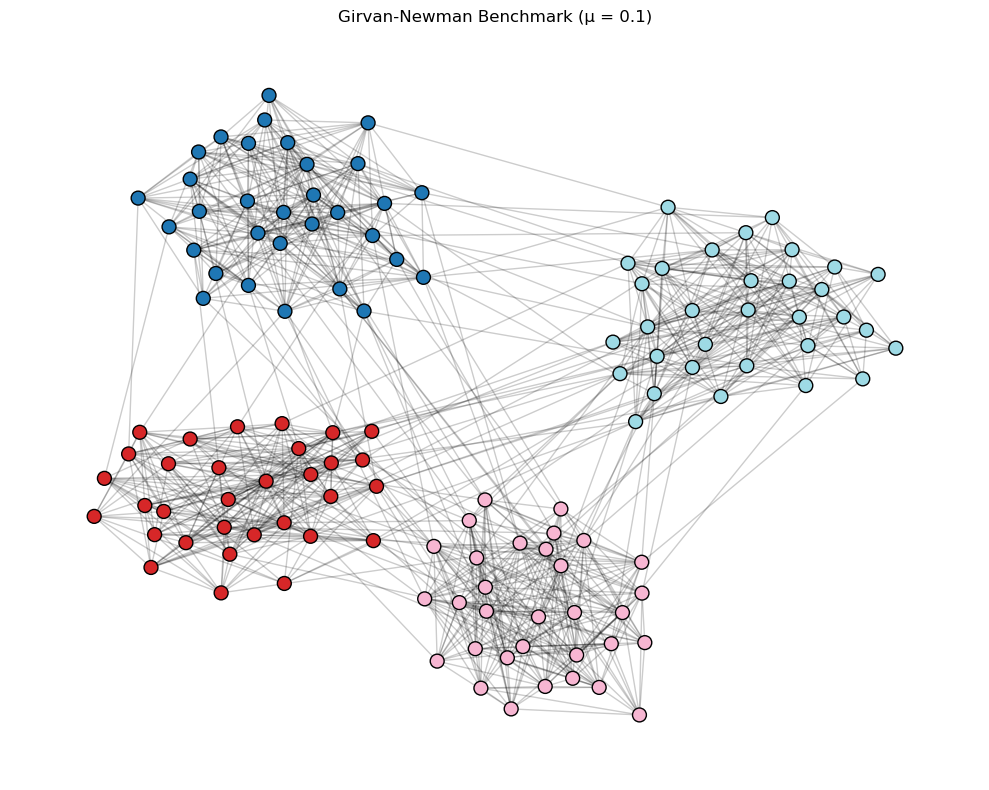

In [22]:
# Visualize the GN benchmark graph
draw_communities(G_gn, ground_truth_gn_partition,
                title=f"Girvan-Newman Benchmark (μ = {mu_gn})")

**Limitations of the GN Benchmark:**

1. **Uniform community sizes**: All communities have exactly the same number of nodes
2. **Poisson degree distribution**: Unlike real networks that typically have power-law (scale-free) distributions
3. **Homogeneous structure**: Communities have identical statistical properties

These limitations make the GN benchmark less realistic for evaluating algorithms on real-world networks. The LFR benchmark addresses these issues.

### 2.3 LFR Benchmark

The **Lancichinetti-Fortunato-Radicchi (LFR)** benchmark is a more realistic model that addresses the limitations of the GN benchmark by incorporating:

1. **Heterogeneous degree distribution**: 
   - Node degrees follow a power-law: $P(k) \sim k^{-\gamma}$ 
   - Controlled by parameter `tau1` ($\gamma$), typically between 2 and 3

2. **Heterogeneous community sizes**:
   - Community sizes follow a power-law: $P(s) \sim s^{-\beta}$
   - Controlled by parameter `tau2` ($\beta$), typically around 1.5-2.0

3. **Configurable mixing parameter**:
   - `mu` ($\mu$) controls the fraction of external connections
   - Can be varied to create benchmarks of different difficulty levels

**Key Parameters:**
- `n`: Number of nodes
- `average_degree`, `min_degree`, `max_degree`: Degree constraints
- `min_community`, `max_community`: Community size constraints
- `mu`: Mixing parameter
- `tau1`: Degree distribution exponent
- `tau2`: Community size distribution exponent

Let's generate an LFR benchmark graph and explore its properties:

In [23]:
# Define LFR benchmark parameters
n_lfr = 250              # Number of nodes
tau1_lfr = 2.5           # Degree distribution exponent
tau2_lfr = 1.5           # Community size distribution exponent
mu_lfr = 0.1            # Mixing parameter 
avg_k_lfr = 5           # Average degree
min_comm_lfr = 20        # Minimum community size
max_comm_lfr = 50        # Maximum community size
min_degree_lfr = 5       # Minimum node degree
max_degree_lfr = 50      # Maximum node degree


In [24]:
# Generate the LFR benchmark graph
G_lfr = nx.generators.community.LFR_benchmark_graph(
    n_lfr, tau1_lfr, tau2_lfr, mu_lfr, 
    average_degree=avg_k_lfr,
    max_degree=max_degree_lfr, 
    min_community=min_comm_lfr, 
    max_community=max_comm_lfr, 
    seed=42
)

# Remove self-loops
G_lfr.remove_edges_from(nx.selfloop_edges(G_lfr))
# Remove isolated nodes
G_lfr.remove_nodes_from(list(nx.isolates(G_lfr)))

ground_truth_lfr_partition = []
for node, attrs in G_lfr.nodes(data=True):
    if attrs['community'] not in ground_truth_lfr_partition:
        ground_truth_lfr_partition.append(attrs['community'])

ground_truth_lfr_labels = partition_to_labels(ground_truth_lfr_partition, G_lfr)        

print(f"\nGenerated LFR benchmark properties:")
print(f"- Nodes: {G_lfr.number_of_nodes()}")
print(f"- Edges: {G_lfr.number_of_edges()}")
print(f"- Actual average degree: {2 * G_lfr.number_of_edges() / G_lfr.number_of_nodes():.2f}")
print(f"- Communities: {len(ground_truth_lfr_partition)}")

# Show community size distribution
comm_sizes = [len(comm) for comm in ground_truth_lfr_partition]
print(f"- Community sizes: min={min(comm_sizes)}, max={max(comm_sizes)}, avg={np.mean(comm_sizes):.1f}")


Generated LFR benchmark properties:
- Nodes: 249
- Edges: 625
- Actual average degree: 5.02
- Communities: 8
- Community sizes: min=20, max=41, avg=31.2


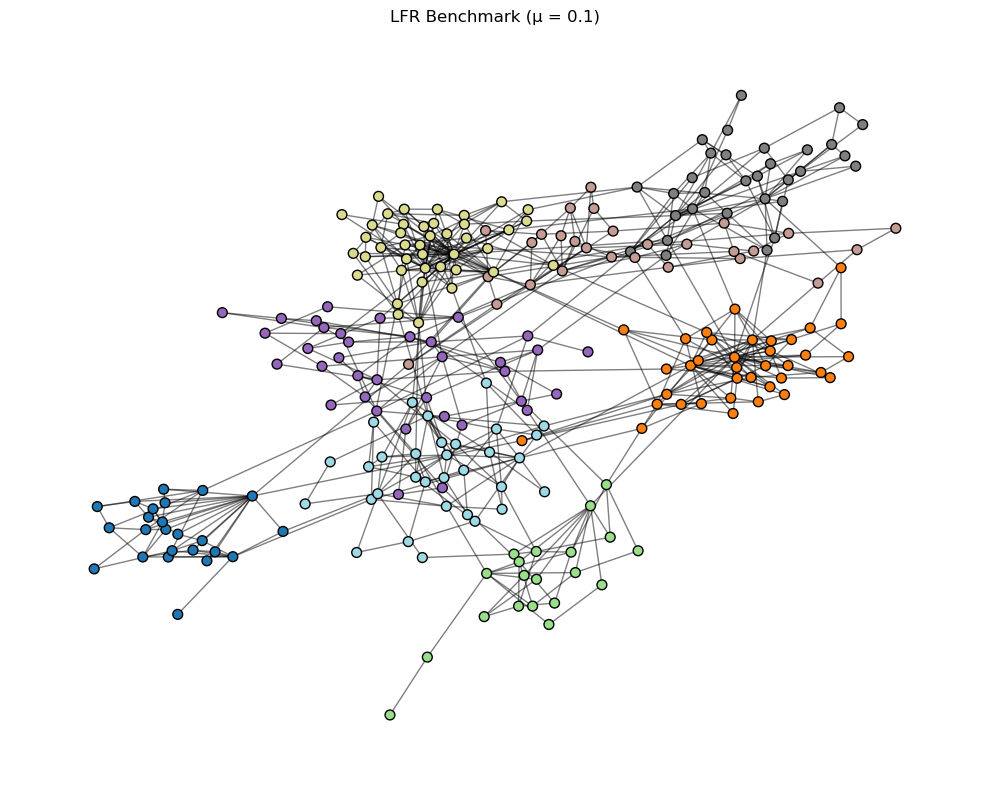

In [25]:
draw_communities(G_lfr, ground_truth_lfr_partition,
                title=f"LFR Benchmark (μ = {mu_lfr})",
                node_size=50, alpha=0.5, with_labels=False)    

## 3. Evaluation Metrics for Community Detection

Before we implement algorithms, it's important to understand how we'll measure their performance. When evaluating community detection algorithms, we need quantitative metrics to compare detected communities against ground truth.

### 3.1 Key Evaluation Metrics

#### Adjusted Rand Index (ARI)
The **Adjusted Rand Index** measures the similarity between two clusterings by considering pairs of nodes:
- It counts how many pairs of nodes are placed in the same or different communities in both partitions
- Ranges from -1 (completely different) to 1 (identical partitions)
- **Adjustment**: Corrects for chance agreement, meaning random partitions should score close to 0
- **Interpretation**: Higher values indicate better agreement with ground truth
- **Student-friendly explanation**: ARI measures "how often do nodes that should be together stay together, and nodes that should be separate stay separate?"

#### Normalized Mutual Information (NMI)
**Normalized Mutual Information** measures how much information one partition provides about another:
- Based on information theory - it quantifies shared information between partitions
- Ranges from 0 (no mutual information) to 1 (perfect correlation)
- **Interpretation**: Higher values indicate better matching partitions
- **Student-friendly explanation**: NMI measures "how much knowing a node's community in one partition tells you about its community in the other partition"

#### Adjusted Mutual Information (AMI)
**Adjusted Mutual Information** is similar to NMI but with correction for chance:
- Adjusts for the fact that random partitions can have non-zero mutual information
- Less biased when comparing partitions with different numbers of communities
- Preferred over NMI when comparing algorithms that produce different numbers of communities
- **Student-friendly explanation**: AMI is like NMI, but it accounts for lucky guesses

#### Modularity
While not a comparison metric, **Modularity** measures the quality of a partition:
- Quantifies how well a network is divided into densely connected communities
- Positive values indicate more connections within communities than expected by chance
- **Limitation**: Modularity has a "resolution limit" and may fail to detect small communities
- **Student-friendly explanation**: Modularity measures "are there more connections inside communities than we would expect in a random network?"

### 3.2 Implementing Algorithm Evaluation
Let's define a helper function to evaluate community detection algorithms on our benchmark graphs.

In [26]:
# Helper function to run and evaluate a community detection algorithm
def evaluate_algorithm(name, algorithm, graph, ground_truth_labels):
    import time
    
    print(f"\nRunning {name}...")
    start_time = time.time()
    
    try:
        # Run the algorithm
        partition = list(algorithm(graph))
        runtime = time.time() - start_time
        
        # Convert to labels and calculate metrics
        detected_labels = partition_to_labels(partition, graph)
        
        ari = metrics.adjusted_rand_score(ground_truth_labels, detected_labels)
        ami = metrics.adjusted_mutual_info_score(ground_truth_labels, detected_labels)
        nmi = metrics.normalized_mutual_info_score(ground_truth_labels, detected_labels)
        
        # Calculate modularity using NetworkX's built-in function
        mod = community.modularity(graph, partition)
        
        # Return results and partition
        results = {
            'Algorithm': name,
            'Communities': len(partition),
            'ARI': ari,
            'AMI': ami,
            'NMI': nmi,
            'Modularity': mod,
            'Runtime (s)': runtime
        }
        
        print(f"  Found {len(partition)} communities in {runtime:.2f} seconds")
        print(f"  ARI: {ari:.4f}, AMI: {ami:.4f}, NMI: {nmi:.4f}")
        print(f"  Modularity: {mod:.4f}")
        
        return partition, results
        
    except Exception as e:
        print(f"  Error running {name}: {e}")
        results = {
            'Algorithm': name,
            'Communities': "Error",
            'ARI': np.nan,
            'AMI': np.nan,
            'NMI': np.nan,
            'Modularity': np.nan,
            'Runtime (s)': np.nan
        }
        return None, results

In [27]:
# Define a custom Girvan-Newman function that stops at max modularity
def girvan_newman_max_modularity(G):
    # Initialize variables to track the best partition
    best_modularity = -1.0
    best_partition = None
    
    # Run the full Girvan-Newman algorithm
    comp_generator = community.girvan_newman(G)
    
    # Evaluate each partition in the hierarchy
    for communities in comp_generator:
        partition = tuple(sorted(c) for c in communities)
        partition_sets = [set(c) for c in partition]
        
        # Calculate modularity
        mod = community.modularity(G, partition_sets)
        
        # Update best partition if modularity is higher
        if mod > best_modularity:
            best_modularity = mod
            best_partition = partition_sets
            
        # For large networks, we might want to stop after a reasonable number of communities
        if len(partition) > 4 * len(ground_truth_lfr_partition) if ground_truth_lfr_partition else 12:
            break
    
    print(f"  Best modularity: {best_modularity:.4f} with {len(best_partition)} communities")
    return best_partition

In [28]:
# Define a more robust Label Propagation that runs multiple times with different seeds
def label_propagation(G, num_runs=10):
    """
    Run Label Propagation multiple times with different random seeds
    and return the partition with the highest modularity score.
    
    Parameters:
    -----------
    G : networkx.Graph
        The input graph
    num_runs : int
        Number of times to run the algorithm with different seeds
        
    Returns:
    --------
    list of sets
        The best partition found (as a list of sets)
    """
    best_modularity = -1.0
    best_partition = None
    
    # Run multiple times with different seeds
    for seed in range(num_runs):
        # Create a copy of the graph to avoid modifying the original
        G_copy = G.copy()
        
        # Add random labels as initial state (helps avoid getting stuck in local optima)
        import random
        random.seed(seed)
        for node in G_copy.nodes():
            G_copy.nodes[node]['label'] = random.randint(0, len(G_copy)//10)
        
        # Run the standard label propagation
        partition = list(community.label_propagation_communities(G_copy))
        
        # Calculate modularity
        modularity = community.modularity(G, partition)
        
        # Keep track of the best partition
        if modularity > best_modularity:
            best_modularity = modularity
            best_partition = partition
            
    print(f"  Best modularity from {num_runs} runs: {best_modularity:.4f}")
    
    # If all runs failed (unlikely), return a simple partition
    if best_partition is None:
        return [set(G.nodes())]
        
    return best_partition

In [29]:
print(f"Comparing algorithms on the LFR benchmark graph")

# Dictionary to store results and partitions
results = []
partitions = {}

# Run each algorithm and collect results

# 1. Greedy Modularity Maximization
partition, result = evaluate_algorithm(
    "Greedy Modularity", 
    community.greedy_modularity_communities, 
    G_lfr, ground_truth_lfr_labels
)
partitions['Greedy Modularity'] = partition
results.append(result)

# 2. Enhanced Label Propagation Algorithm
partition, result = evaluate_algorithm(
    "Label Propagation", 
    label_propagation, 
    G_lfr, ground_truth_lfr_labels
)
partitions['Label Propagation'] = partition
results.append(result)

# 3. Louvain Method
partition, result = evaluate_algorithm(
    "Louvain", 
    community.louvain_communities, 
    G_lfr, ground_truth_lfr_labels
)
partitions['Louvain'] = partition
results.append(result)

# 4. Girvan-Newman algorithm (can be slow on large networks)
if G_lfr.number_of_nodes() <= 250:  # Only run if network is small enough
    partition, result = evaluate_algorithm(
        "Girvan-Newman",
        girvan_newman_max_modularity,
        G_lfr, ground_truth_lfr_labels
    )
    partitions['GN'] = partition
    results.append(result)

Comparing algorithms on the LFR benchmark graph

Running Greedy Modularity...
  Found 8 communities in 0.02 seconds
  ARI: 0.8861, AMI: 0.9390, NMI: 0.9422
  Modularity: 0.7624

Running Label Propagation...
  Best modularity from 10 runs: 0.7354
  Found 13 communities in 0.03 seconds
  ARI: 0.8044, AMI: 0.8839, NMI: 0.8932
  Modularity: 0.7354

Running Louvain...
  Found 8 communities in 0.01 seconds
  ARI: 0.8916, AMI: 0.9474, NMI: 0.9502
  Modularity: 0.7622

Running Girvan-Newman...
  Best modularity: 0.7624 with 8 communities
  Found 8 communities in 3.08 seconds
  ARI: 0.8861, AMI: 0.9390, NMI: 0.9422
  Modularity: 0.7624


In [30]:
# Create and display results table
if 'results' in locals() and results:
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    display(results_df)
    
    # Filter out failed algorithms
    valid_results = results_df.dropna()
    
    # Highlight the best performing algorithm for each metric
    highlighted_df = results_df.style.highlight_max(subset=['ARI', 'AMI', 'NMI', 'Modularity'], color='lightgreen')
    display(highlighted_df)

,Algorithm,Communities,ARI,AMI,NMI,Modularity,Runtime (s)
0,Greedy Modularity,8,0.886050,0.938962,0.942211,0.762382,0.018751
1,Label Propagation,13,0.804450,0.883861,0.893247,0.735377,0.029913
2,Louvain,8,0.891595,0.947391,0.950194,0.762203,0.005244
3,Girvan-Newman,8,0.886050,0.938962,0.942211,0.762382,3.080939


,Algorithm,Communities,ARI,AMI,NMI,Modularity,Runtime (s)
0,Greedy Modularity,8,0.886050,0.938962,0.942211,0.762382,0.018751
1,Label Propagation,13,0.804450,0.883861,0.893247,0.735377,0.029913
2,Louvain,8,0.891595,0.947391,0.950194,0.762203,0.005244
3,Girvan-Newman,8,0.886050,0.938962,0.942211,0.762382,3.080939


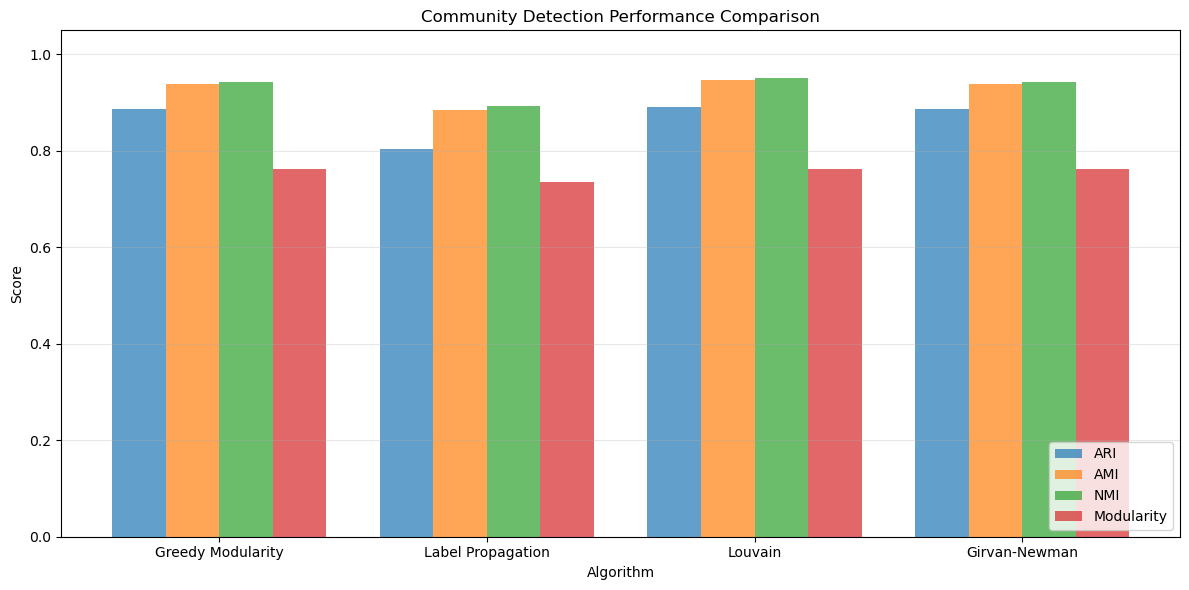

In [31]:
# Visualize algorithm performance comparison
if 'valid_results' in locals() and not valid_results.empty:
    plt.figure(figsize=(12, 6))

    # Create a grouped bar chart
    metrics_to_plot = ['ARI', 'AMI', 'NMI', 'Modularity']
    barwidth = 0.2
    x = np.arange(len(valid_results))

    for i, metric in enumerate(metrics_to_plot):
        plt.bar(x + i*barwidth, valid_results[metric], width=barwidth, 
                label=metric, alpha=0.7)

    plt.xlabel('Algorithm')
    plt.ylabel('Score')
    plt.title('Community Detection Performance Comparison')
    plt.xticks(x + barwidth*1.5, valid_results['Algorithm'])
    plt.ylim(0, 1.05)
    plt.legend(loc='lower right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


Visualizing communities detected by Louvain (highest AMI):


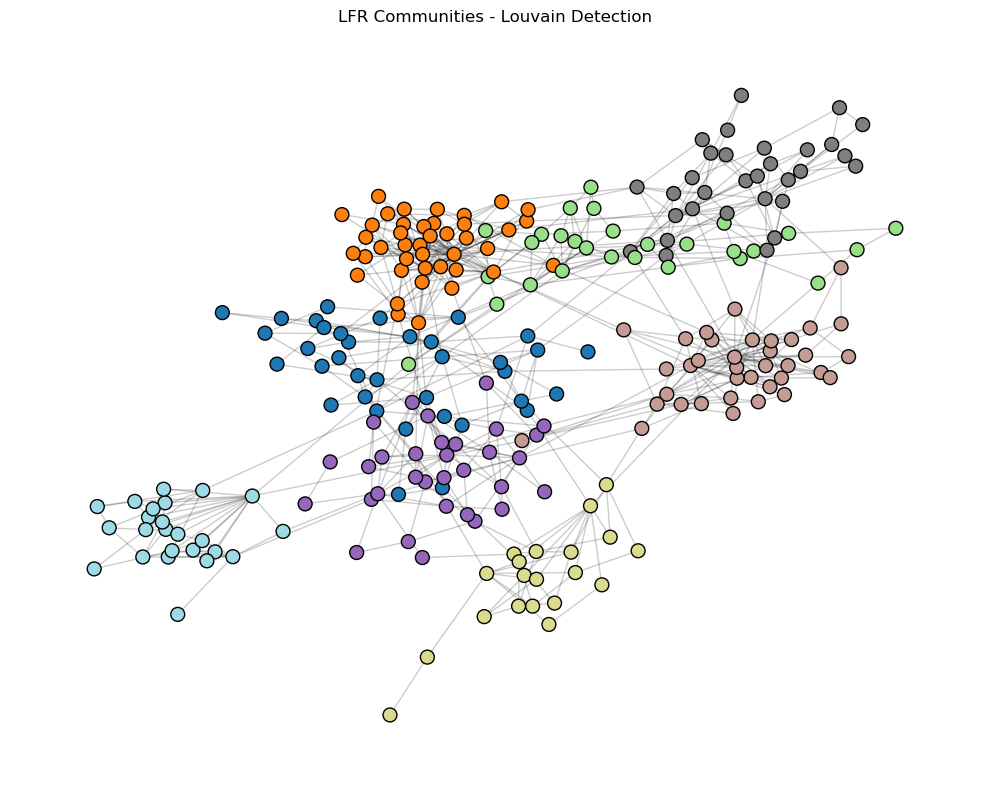

In [32]:
# Visualize the best-performing algorithm's detected communities
if 'valid_results' in locals() and not valid_results.empty and 'partitions' in locals():
    # Find the best algorithm based on AMI score
    best_algo = valid_results.loc[valid_results['AMI'].idxmax(), 'Algorithm']

    if best_algo in partitions and partitions[best_algo]:
        print(f"\nVisualizing communities detected by {best_algo} (highest AMI):")
        draw_communities(G_lfr, partitions[best_algo],
                       title=f"LFR Communities - {best_algo} Detection")

## 4. Conclusion and Best Practices

### Key Takeaways

1. **Evaluating community detection requires:**
   - Appropriate benchmarks (artificial and real-world)
   - Reliable ground truth communities
   - Multiple quantitative metrics (ARI, AMI)
   - Testing on negative controls (random graphs)

2. **Benchmarks offer different advantages:**
   - **Artificial benchmarks** (PPM, GN, LFR) allow controlled testing
   - **LFR** provides more realistic network structures with power-law distributions
   - **Real networks** test performance on empirical data with natural community structures
   - **Negative controls** help identify algorithms that overfit to random fluctuations

3. **No single algorithm performs best in all scenarios:**
   - Algorithm performance depends on network properties
   - Different algorithms have different strengths and weaknesses
   - LPA is fast but less accurate on weak communities
   - Modularity-based methods work well on many networks but suffer from resolution limit

4. **Metrics reveal different aspects of performance:**
   - **ARI** focuses on pairwise node relationships
   - **AMI/NMI** focus on overall partition information
   - Both are adjusted for chance agreement
   - Higher values indicate better agreement with ground truth

### Best Practices for Evaluating Community Detection

1. **Use multiple benchmarks** with different characteristics
2. **Vary difficulty levels** (e.g., different mixing parameters)
3. **Compare multiple algorithms** on the same benchmarks
4. **Use multiple evaluation metrics** (ARI + AMI at minimum)
5. **Include negative controls** to test for overfitting
6. **Report algorithm parameters** for reproducibility
7. **Consider practical constraints** (runtime, memory requirements)

By following these practices, you can reliably evaluate community detection algorithms and select the most appropriate one for your specific network analysis tasks.

## 5. Exercises for Students

1. **Benchmark Exploration:**
   - Generate an LFR benchmark with a different mixing parameter (e.g., μ = 0.4, 0.5, or 0.6)
   - At what mixing parameter value do the algorithms start to fail (ARI/AMI < 0.5)?
   - How does this threshold relate to the theoretical detectability limit?

2. **Algorithm Comparison:**
   - Run the `leiden` algorithm (if available in your NetworkX version) on the benchmarks
   - How does it compare to Louvain in terms of accuracy and runtime?
   - Try modifying the resolution parameter - what effect does this have?

3. **Resolution Limit Investigation:**
   - Create a benchmark with communities of very different sizes
   - Test if modularity-based methods struggle to detect small communities
   - Can you find a better algorithm for detecting communities of varying sizes?

4. **Real Network Analysis:**
   - Find another real network dataset with known ground truth communities
   - Apply the algorithms and metrics we've covered
   - Write a brief report on which algorithm performs best and why

5. **Challenging Case:**
   - Create a benchmark where communities are connected in a hierarchical structure
   - How well do the algorithms detect communities at different hierarchical levels?
   - Can you modify any metrics to better evaluate hierarchical community detection?

## 6. Additional Resources

### Further Reading
- **Original Papers:**
  - Fortunato, S. (2010). Community detection in graphs. Physics Reports, 486(3-5), 75-174.
  - Lancichinetti, A., Fortunato, S., & Radicchi, F. (2008). Benchmark graphs for testing community detection algorithms. Physical Review E, 78(4), 046110.

- **Software Documentation:**
  - [NetworkX Community Detection](https://networkx.org/documentation/stable/reference/algorithms/community.html)
  - [scikit-learn Clustering Metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

### Advanced Topics
- Resolution limit in modularity-based methods
- Overlapping community detection
- Dynamic community detection in temporal networks
- Hierarchical community structure

### Online Tools
- [SNAP Datasets](https://snap.stanford.edu/data/) - Real networks with metadata
- [LFR Benchmark Generator](https://github.com/eXascaleInfolab/LFR-Benchmark_UndirWeightOvp) - Advanced implementation
- [Community Detection Visualization Tools](https://github.com/upphiminn/d3.js-force-directed-graph) - D3.js visualizations